# Read in data

In [1]:
import pandas as pd
import altair as alt
import numpy as np

In [2]:
rankings_global_and_biome = pd.read_csv('param_rankings_v3.csv')

In [3]:
param_descriptions = pd.read_csv('param_list_CLM5PPE.csv')

# Process data

In [5]:
#rankings = pd.concat([rankings_global_and_biome, rankings_LAC], ignore_index=True)
rankings=rankings_global_and_biome
rankings=rankings.drop(columns=['Unnamed: 0'])
rankings['biome_type']=rankings.biome.where(rankings.biome=='global','regional')
param_descriptions['param_name']=param_descriptions['param']

In [6]:
variables = ['EFLX_LH_TOT', 'FSH', 'Q2M','ET',
             'TAUX',        'TAUY','U10',
             'TSKIN',       'TSA', 'FIRE',
             'albedo_allSW','FSA', 'alb_DifNIR','alb_DirNIR','alb_DifVis','alb_DirVis']
variable_categories = ['WaterAndTurbFluxes','WaterAndTurbFluxes','WaterAndTurbFluxes','WaterAndTurbFluxes',
            'MomentumAndResistance','MomentumAndResistance','MomentumAndResistance',
            'TemperatureAndLW','TemperatureAndLW','TemperatureAndLW',
            'AlbedoAndSW','AlbedoAndSW','AlbedoAndSW','AlbedoAndSW','AlbedoAndSW','AlbedoAndSW']
df_variable_crosswalk = pd.DataFrame({'variable': variables, 
                          'variable_category': variable_categories})

In [7]:
rankings_merged = (pd.merge(rankings, param_descriptions, how='left',on='param_name'))
rankings_merged = (pd.merge(rankings_merged, df_variable_crosswalk, how='left',on='variable'))

In [8]:
rankings_merged['Category3'] = rankings_merged['Category2'].where(~rankings_merged['Category2'].isin(['Plant photosynthesis numerical implementation',
                                                                                                      'Soil nitrogen cycle',
                                                                                                      'Soil decomposition',
                                                                                                      'Plant carbon and nitrogen allocation',
                                                                                                      'Plant respiration',
                                                                                                      'Plant nitrogen fixation and uptake',
                                                                                                     'Biomass heat storage'
                                                                                                     ]),
                                                                  'Other')

In [9]:
rankings_merged = rankings_merged[~(rankings_merged.variable=='ET')&
                                  ~(rankings_merged.variable=='TAUY')&
                                  ~(rankings_merged.variable=='alb_DirNIR')&
                                  ~(rankings_merged.variable=='alb_DirVis')&
                                 ~(rankings_merged.variable=='alb_DifNIR')&
                                 ~(rankings_merged.variable=='alb_DifVis')]

In [10]:
rankings_merged['criteria_type']=rankings_merged['variable']+'_'+rankings_merged['measure']

# List of ranked top parameters (export to csv)

In [ ]:
source=rankings_merged
source2 = source[source['rank']<=5]
param_list2 = pd.pivot_table(source2, index=["param_name"], columns=["variable"], values=["rank"], aggfunc='count')
param_list2['total']=source2['rank'].groupby(source2["param_name"]).count().values
param_list2=(pd.merge(param_list2, param_descriptions, how='left',on='param_name'))

/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [ ]:
source=rankings_merged
source = source[source['rank']<=3]
param_list = pd.pivot_table(source, index=["param_name"], columns=["variable"], values=["rank"], aggfunc='count')
param_list['total']=source['rank'].groupby(source["param_name"]).count().values
param_list.columns = [f'{j}_{i}' for i, j in param_list.columns]
param_list=param_list.rename(columns=
                             {"EFLX_LH_TOT_rank":"EFLX_LH_TOT",
                             "FIRE_rank":"FIRE",
                             "FSA_rank":"FSA",
                             "FSH_rank":"FSH",
                             "LAC_rank":"LAC",
                             "Q2M_rank":"Q2M",
                              "TSA_rank":"TSA",
                              "TAUX_rank":"TAUX",
                              "TSKIN_rank":"TSKIN",
                              "U10_rank":"U10",
                              "albedo_allSW_rank":"albedo_allSW",
                              "_total":"total"
                             })
#
#param_list.to_csv('Top_Params_v2.csv')

In [ ]:
param_list=param_list.fillna(0)
param_list['Water_and_Turbulent']=(param_list['EFLX_LH_TOT']+
                                   param_list['FSH']+
                                   param_list['Q2M'])/3
param_list['Albedo_and_SW']=(param_list['albedo_allSW']+
                             param_list['FSA'])/2
param_list['Temperature']=(param_list['FIRE']+
                           param_list['TSA']+
                           param_list['TSKIN'])/3
param_list['Wind_and_Roughness']=(param_list['TAUX']+
                           param_list['U10'])/2

param_list['total_weighted']=(param_list['Water_and_Turbulent']+
                              param_list['Albedo_and_SW']+
                              param_list['Temperature']+
                              param_list['Wind_and_Roughness']+
                              param_list['LAC'])

In [ ]:
param_list=(pd.merge(param_list, param_descriptions, how='left',on='param_name'))
param_list.to_csv('New_params.csv')

# Code for visualizations

In [10]:
source=rankings_merged

In [11]:
biome_order=['Ice sheet',
             'Subtropical desert',
             'Temperate grassland/desert',
             'Tundra',
             'Woodland/shrubland',
             'Temperate seasonal forest',
             'Tropical seasonal forest/savanna',
             'Temperate rain forest',
             'Boreal forest',
             'Tropical rain forest',
             'global']

In [13]:
var_list=np.unique(rankings_merged.variable).tolist()
var_dropdown = alt.binding_select(options=var_list)
var_select = alt.selection_single(fields=['variable'], bind=var_dropdown, name="Variable",
                                 init={'variable':'EFLX_LH_TOT'})

region_list=np.unique(rankings_merged.biome).tolist()
region_dropdown = alt.binding_select(options=region_list)
region_select = alt.selection_single(fields=['biome'], bind=region_dropdown, name="Biome",
                                 init={'biome':'global'})

measure_list = np.unique(rankings_merged.measure).tolist()
measure_dropdown = alt.binding_select(options=measure_list)
measure_select = alt.selection_single(fields=['measure'], bind=measure_dropdown, name="Measure",
                                 init={'measure':'mean'})

param_list=rankings_merged.param_name.value_counts().index.tolist()
param_dropdown = alt.binding_select(options=np.unique(param_list).tolist())
param_select = alt.selection_single(fields=['param_name'], bind=param_dropdown, name="Parameter",
                                 init={'param_name':'lmrse'})

category2_list=rankings_merged.Category2.value_counts().index.tolist()
category_dropdown = alt.binding_select(options=np.unique(category2_list).tolist())
category_select= alt.selection_single(fields=['Category2'], bind=category_dropdown, name="Parameter Category",
                                 init={'Category2':'Plant temperature acclimation'})

category3_list=rankings_merged.Category3.value_counts().index.tolist()

In [14]:
chart_by_variable = alt.Chart(source, title="Parameter Counts by Output Variable").add_selection(
    var_select
).transform_filter(
    var_select
).mark_bar().encode(
    x=alt.X('count(param_name):Q', title='# of Times Parameter in Top 5'),
    y=alt.Y('param_name:N',title='Parameter Name', 
           sort=alt.EncodingSortField(field="param_name", op="count", order='descending')),
    opacity=alt.Opacity('biome_type:N', sort=['regional','global'], title='Biome Type'),
    color=alt.Color('Category2:N',title='Parameter Category', scale=alt.Scale(scheme='category20',domain=category2_list)),
    tooltip=[alt.Tooltip('param_name',title='Parameter Name'),
             alt.Tooltip('Description',title='Description'),
             alt.Tooltip('Category2',title='Parameter Category'),
            ],
)

In [15]:
chart_by_variable_region_measure = alt.Chart(source, title="Parameter Counts by Output Variable").add_selection(
    var_select,
    region_select,
    measure_select
).transform_filter(var_select).transform_filter(region_select).transform_filter(measure_select
).mark_bar().encode(
    x=alt.X('rank:Q', title='# of Times Parameter in Top 5'),
    y=alt.Y('param_name:N',title='Parameter Name', 
           sort=alt.EncodingSortField(field="rank", order='ascending')),
    color=alt.Color('Category2:N',title='Parameter Category', scale=alt.Scale(scheme='category20',domain=category2_list)),
)

In [16]:
chart_by_region = alt.Chart(source, title="Parameter Counts by Region").add_selection(
    region_select
).transform_filter(
    region_select
).mark_bar().encode(
    x=alt.X('count(param_name):Q', title='# of Times Parameter in Top 5 List'),
    y=alt.Y('param_name:N',title='Parameter Name', 
           sort=alt.EncodingSortField(field="param_name", op="count", order='descending')),
    color=alt.Color('Category2:N',title='Parameter Category', scale=alt.Scale(scheme='category20',domain=category2_list)),
    tooltip=[alt.Tooltip('param_name',title='Parameter Name'),
             alt.Tooltip('Description',title='Description'),
             alt.Tooltip('Category2',title='Parameter Category'),
            ],
)

In [17]:
base = alt.Chart(source).mark_bar().encode(
    x=alt.X('count(param_name):Q', title='# of Times Parameter in Top 5'),
    y=alt.Y('param_name:N',title='Parameter Name', 
           sort=alt.EncodingSortField(field="param_name", op="count", order='descending')),
    opacity=alt.Opacity('biome_type:N', sort=['regional','global'], title='Biome Type'),
    color=alt.Color('Category2:N',title='Parameter Category', scale=alt.Scale(scheme='category20',domain=category2_list)),
                   # scale=alt.Scale(scheme = 'category20')),
tooltip=[alt.Tooltip('param_name',title='Parameter Name'),
         alt.Tooltip('Description',title='Description'),
        alt.Tooltip('Category2',title='Parameter Category'),
        alt.Tooltip('biome_type',title='Global or Regional Top 5 List?')],
).properties(
    width=400,
    height=600
)

In [18]:
#criteria_type_list = []
#for var in np.unique(source.variable).tolist():
#    criteria_type_list.append(var+'_mean')
#for var in np.unique(source.variable).tolist():
#    criteria_type_list.append(var+'_iav')

# Base chart for data tables
ranked_vars = alt.Chart(source).mark_text().encode(
    #y=alt.Y('criteria_type:N', scale=alt.Scale(domain=criteria_type_list),title='Output Variable'),
    y=alt.Y('variable:N', scale=alt.Scale(domain=np.unique(source.variable).tolist()),title='Output Variable'),
    x=alt.X('biome:N', scale=alt.Scale(domain=biome_order),
           title='Biome'),
    color=alt.Color('average(rank):Q',scale=alt.Scale(domain=[0,6], scheme='yellowgreenblue')),
    tooltip=[alt.Tooltip('param',title='Parameter Name'),
             alt.Tooltip('Description',title='Parameter description'),
             alt.Tooltip('Category2',title='Parameter Category'),
             alt.Tooltip('variable',title='Variable'),
             #alt.Tooltip('measure',title='Measure'),
             alt.Tooltip('biome',title='Biome'),
             alt.Tooltip('count(param_name):N',title='Number of times in top 5'),
             alt.Tooltip('mean(rank):Q',title='Average rank when in top 5'),
             ],
).add_selection(param_select).transform_filter(param_select)

# Data Tables
param_stats = ranked_vars.mark_bar()

In [19]:
top5counts_bycategory = alt.Chart(source).mark_bar().add_selection(category_select).transform_filter(category_select).encode(
    x=alt.X('count(param_name):Q', title='# of Times Parameter in Top 5',
           scale=alt.Scale(domain=[0,110])),
    y=alt.Y('param_name:N',title='Parameter Name', 
           sort=alt.EncodingSortField(field="param_name", op="count", order='descending')),
    opacity=alt.Opacity('biome_type:N', sort=['regional','global'], title='Biome Type'),
    color=alt.Color('Category2:N',title='Parameter Category', scale=alt.Scale(scheme='category20',domain=category2_list)),
                   # scale=alt.Scale(scheme = 'category20')),
tooltip=[alt.Tooltip('param_name',title='Parameter Name'),
         alt.Tooltip('Description',title='Description'),
        alt.Tooltip('count(param_name):Q',title='# of Times Parameter in Top 5')],
)

In [20]:
param_categories = alt.Chart(source).mark_bar().encode(
    x=alt.X('Category2:N',
            sort=alt.EncodingSortField(field="param_name", op="count", order='descending')),
    y='count(param_name):Q',
    color=alt.Color('Category2:N',title='Parameter Category', scale=alt.Scale(scheme='category20',domain=category2_list)),
)

# Show figures

### Number of times each parameter is in a top 5 list

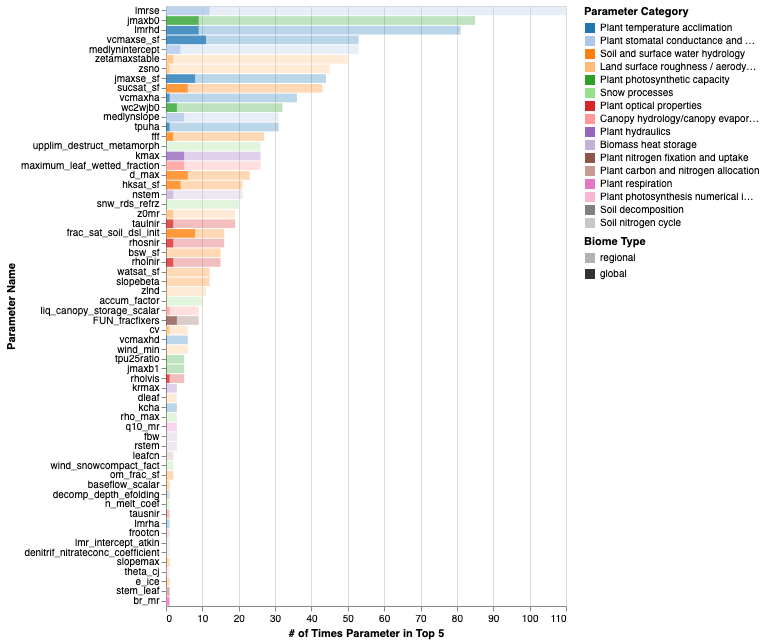

In [21]:
base

### Top 5 Counts by Parameter Category

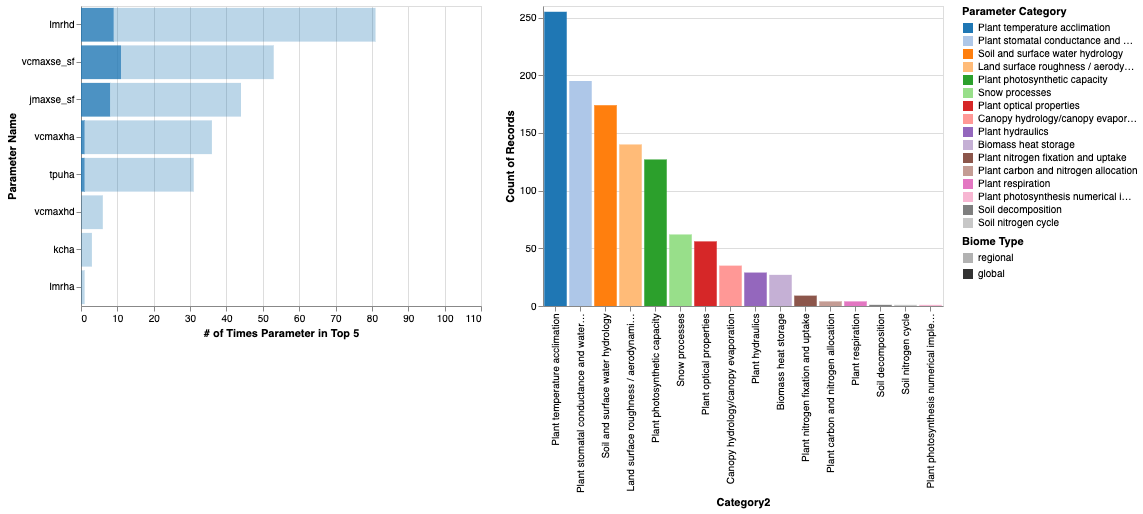

In [23]:
(top5counts_bycategory | param_categories).save('Top5Counts_byParameterCategory.html')
top5counts_bycategory | param_categories

### Top 5 Counts by Region

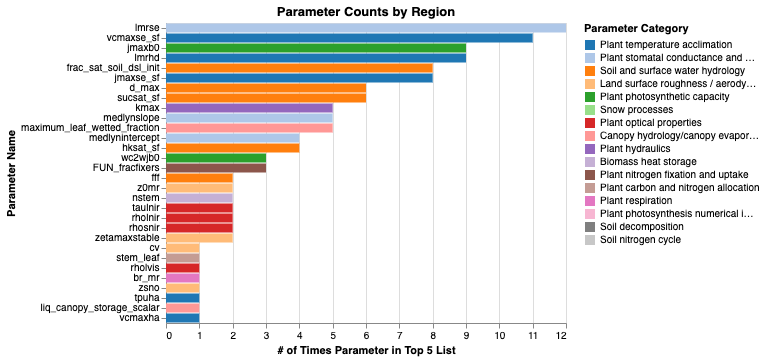

In [24]:
chart_by_region

### Top 5 Counts by Output Variable

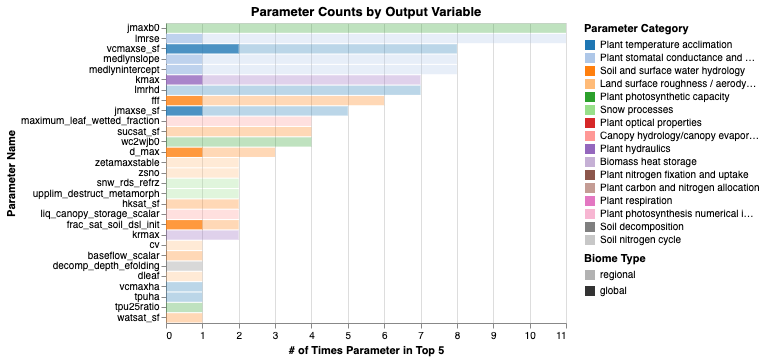

In [25]:
chart_by_variable

### For which metrics is a parameter in the top 5?

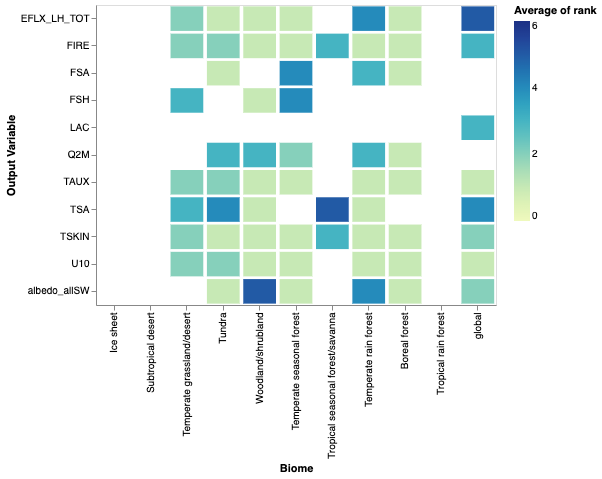

In [26]:
param_stats.add_selection(measure_select).transform_filter(measure_select)